# Perturbation loss & activation pattern metric - German Traffic Sign Recognition Benchmark (GTSRB)



In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy.random
# Fix the number for repeatability (we have also stored the trained model)
numpy.random.seed(42)

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Start by accessing the root folder where internally, subfolders are images with folder name being their classified result.

The dataset should be available at the following site 
http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset

Here we just pick the 26K smaller training set (the online version), as the training and test set can all be directly loaded using PyTorch included functionalities. 

In [4]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

standard_transform = transforms.Compose([
        transforms.ToTensor(),
        # Change the image to PIL format, such that resize can be done
        transforms.ToPILImage(),
        transforms.Resize((32,32)),
        # Bring it back to tensor
        transforms.ToTensor()
    ])

# Here the data is not be normalized to [-1,1]

# Change the folder based on your specific needs. 
# This one is a smaller (26640 examples) data set (for online training), so the 
data = ImageFolder(root=r"C:\Users\Shoaib\Desktop\nn-dependability-kit-master\data\GTSRB\Training",  transform=standard_transform)


In [5]:
print(data.classes)

['00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023', '00024', '00025', '00026', '00027', '00028', '00029', '00030', '00031', '00032', '00033', '00034', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00042']


- 0 	 Speed limit (20km/h)
- 1 	 Speed limit (30km/h)
- 2 	 Speed limit (50km/h)
- 3 	 Speed limit (60km/h)
- 4 	 Speed limit (70km/h)
- 5 	 Speed limit (80km/h)
- 6 	 End of speed limit (80km/h)
- 7 	 Speed limit (100km/h)
- 8 	 Speed limit (120km/h)
- 9 	 No passing
- 10 	 No passing for vechiles over 3.5 metric tons
- 11 	 Right-of-way at the next intersection
- 12 	 Priority road
- 13 	 Yield
- 14 	 Stop
- 15 	 No vechiles
- 16 	 Vechiles over 3.5 metric tons prohibited
- 17 	 No entry
- 18 	 General caution
- 19 	 Dangerous curve to the left
- 20 	 Dangerous curve to the right
- 21 Double curve
- 22 	 Bumpy road
- 23 	 Slippery road
- 24 	 Road narrows on the right
- 25 	 Road work
- 26 	 Traffic signals
- 27 	 Pedestrians
- 28 	 Children crossing
- 29 	 Bicycles crossing
- 30 	 Beware of ice/snow
- 31 	 Wild animals crossing
- 32 	 End of all speed and passing limits
- 33 	 Turn right ahead
- 34 	 Turn left ahead
- 35 	 Ahead only
- 36 	 Go straight or right
- 37 	 Go straight or left
- 38 	 Keep right
- 39 	 Keep left
- 40 	 Roundabout mandatory
- 41 	 End of no passing
- 42 	 End of no passing by vechiles over 3.5 metric tons



In [6]:
# Hyper-parameters 
num_classes = 43
learning_rate = 0.001
sizeOfNeuronsToMonitor = 84
batch_size = 64
num_epochs = 5

In [7]:
from torch.utils.data import DataLoader

loader = DataLoader(data, batch_size=batch_size, shuffle=True)

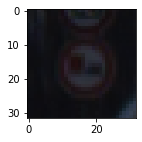

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import util

# get some random training images
dataiter = iter(loader)
images, labels = dataiter.next()

# print(images.shape)
util.displayGTSRB(images[0].numpy())


In [9]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 40, 5)
        self.conv1_bn = nn.BatchNorm2d(40)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(40, 20, 5)
        self.conv2_bn = nn.BatchNorm2d(20)
        self.fc1 = nn.Linear(20 * 5 * 5, 240)        
        self.fc2 = nn.Linear(240, sizeOfNeuronsToMonitor)
        self.fc3 = nn.Linear(sizeOfNeuronsToMonitor, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1_bn(self.conv1(x))))
        x = self.pool(F.relu(self.conv2_bn((self.conv2(x)))))
        # Flatten it to an array of inputs
        x = x.view(-1, 20 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x 

    def forwardWithIntermediate(self, x):
        x = self.pool(F.relu(self.conv1_bn(self.conv1(x))))
        x = self.pool(F.relu(self.conv2_bn((self.conv2(x)))))
        # Flatten it to an array of inputs
        x = x.view(-1, 20 * 5 * 5)
        x = F.relu(self.fc1(x))
        intermediateValues = F.relu(self.fc2(x))
        x = self.fc3(intermediateValues)
        return x , intermediateValues


In [10]:
net = Net()

In [11]:
# .. to load pre-trained model:
net.load_state_dict(torch.load('models/3_model_GTSRB_CNN_27k_train99%.ckpt'))

In [12]:
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  

furtherTrain = False

if furtherTrain: 

    # Train the model
    total_step = len(loader)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loader):  
            # Move tensors to the configured device
            labels = labels.to(device)

            # Forward pass
            outputs = net(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))


    print('Finished Training')

For testing, we should also use the test data, where they are separated into folders based on their classes, followed by shuffling.

In [13]:
from torch.utils.data import DataLoader

testdata = ImageFolder(root=r"C:\Users\Shoaib\Desktop\nn-dependability-kit-master\data\GTSRB\Online-Test-sort", transform=standard_transform)
testloader = DataLoader(testdata, shuffle=True)

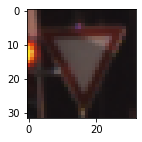

In [14]:
dataiter = iter(testloader)
images, labels = dataiter.next()

util.displayGTSRB(images[0].numpy())

In [15]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print(predicted)
print(labels)

tensor([13])
tensor([13])


In [16]:
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))

with torch.no_grad():
    
    correct = 0
    total = 0
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels)
        label = labels[0]
        class_correct[label] += c[0].item()
        class_total[label] += 1
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network over test images: {} %\n\n'.format(100 * correct / total))

for i in range(num_classes):
    print('Accuracy of %5s : %2d %%' % (
        i, 100 * class_correct[i] / class_total[i]))
    

Accuracy of the network over test images: 96.39589466146869 %


Accuracy of     0 : 88 %
Accuracy of     1 : 98 %
Accuracy of     2 : 98 %
Accuracy of     3 : 98 %
Accuracy of     4 : 95 %
Accuracy of     5 : 92 %
Accuracy of     6 : 97 %
Accuracy of     7 : 98 %
Accuracy of     8 : 96 %
Accuracy of     9 : 98 %
Accuracy of    10 : 98 %
Accuracy of    11 : 95 %
Accuracy of    12 : 99 %
Accuracy of    13 : 99 %
Accuracy of    14 : 96 %
Accuracy of    15 : 93 %
Accuracy of    16 : 100 %
Accuracy of    17 : 99 %
Accuracy of    18 : 97 %
Accuracy of    19 : 100 %
Accuracy of    20 : 99 %
Accuracy of    21 : 37 %
Accuracy of    22 : 98 %
Accuracy of    23 : 87 %
Accuracy of    24 : 94 %
Accuracy of    25 : 99 %
Accuracy of    26 : 91 %
Accuracy of    27 : 100 %
Accuracy of    28 : 91 %
Accuracy of    29 : 62 %
Accuracy of    30 : 92 %
Accuracy of    31 : 96 %
Accuracy of    32 : 100 %
Accuracy of    33 : 95 %
Accuracy of    34 : 100 %
Accuracy of    35 : 99 %
Accuracy of    36 : 100 %
Accur

In [17]:
with torch.no_grad():
    
    correct = 0
    total = 0
    for data in loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network over train images: {} %\n\n'.format(100 * correct / total))


    

Accuracy of the network over train images: 99.9024024024024 %




## A. Metrics on confidence drop due to perturbation


We want to see how much confidence drop can an image (or precisely, the complete set of images in training or testing set) can be, by systematically perturbing the message using various effects.

There are also some other modification possibilities, such as adding snow, rain, fog. Details can be found in 
E.g., https://github.com/UjjwalSaxena/Automold--Road-Augmentation-Library 

In [18]:
from nndependability.metrics import PerturbationLoss

metric1 = PerturbationLoss.Perturbation_Loss_Metric()

Here we try to compute the perturbation loss, by feeding the first 2 batches in the data loader

In [19]:
index = 0
NUMBER_BATCHES_TO_RECORD = 4

for data in loader:    
    if index > NUMBER_BATCHES_TO_RECORD :
        break
    else:
        index = index + 1
        
    for i in range(len(data[0])):
        image = data[0][i].numpy()
        label = data[1][i].numpy()
        #util.displayGTSRB(image)
        metric1.addInputs(net, image, label)


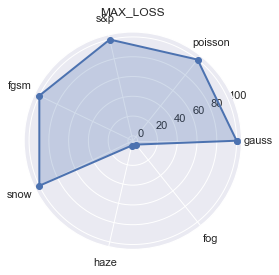

In [20]:
metric1.printMetricQuantity("MAX_LOSS")

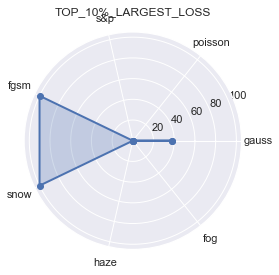

In [21]:
metric1.printMetricQuantity("TOP_10%_LARGEST_LOSS")

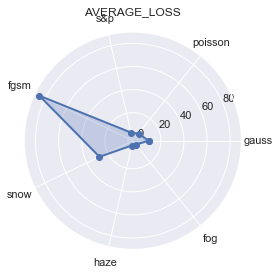

In [22]:
metric1.printMetricQuantity("AVERAGE_LOSS")

Let's visualize the effect on one image

(9, 1.0)


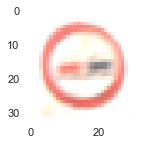

In [23]:
import util
image = data[0][6].numpy()
label = data[1][6].numpy()

util.displayGTSRB(image)
print(PerturbationLoss.evaluateImageAndComputeSoftmax(net, image, label))

We show some perturbations as being prebuilt in the PerturbationLoss metric, the computed class and the probability of the correct label is also shown. 

(15, 0.21978351)
(9, 1.0)
(9, 1.0)
(16, 0.00040120195)
(9, 1.0)
(9, 1.0)
(9, 1.0)


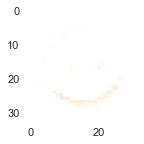

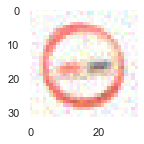

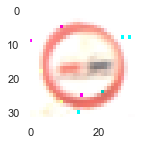

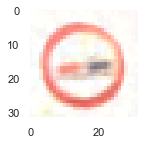

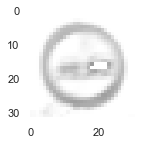

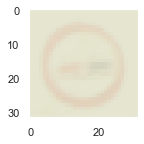

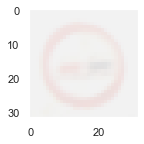

In [24]:
imageFor = np.moveaxis(image, 0, -1)

# Gaussian noise
result1 = np.moveaxis(PerturbationLoss.add_noise("gauss", imageFor), -1, 0)
util.displayGTSRB(result1)
print(PerturbationLoss.evaluateImageAndComputeSoftmax(net, result1, label))

# poisson noise
result2 = np.moveaxis(PerturbationLoss.add_noise("poisson", imageFor), -1, 0)
util.displayGTSRB(result2)
print(PerturbationLoss.evaluateImageAndComputeSoftmax(net, result2, label))

# salt-and-pepper
result3 = np.moveaxis(PerturbationLoss.add_noise("s&p", imageFor), -1, 0)
util.displayGTSRB(result3)
print(PerturbationLoss.evaluateImageAndComputeSoftmax(net, result3, label))

# FGSM
img = (torch.from_numpy(image)).unsqueeze(0)
lab = (torch.from_numpy(label)).unsqueeze(0)
adv_img, noise, attackSuccessful = PerturbationLoss.iterative_FGSM_attack(img, lab, net)
util.displayGTSRB(adv_img.numpy()[0])
PerturbationLoss.evaluateImageAndComputeSoftmax(net, adv_img.numpy()[0], label)
print(PerturbationLoss.evaluateImageAndComputeSoftmax(net, adv_img.numpy()[0], label))

# Snow
imagep = PerturbationLoss.add_weather(imageFor, "snow")
result5 = np.moveaxis(imagep/255.0, -1, 0)
util.displayGTSRB(result5)
PerturbationLoss.evaluateImageAndComputeSoftmax(net, result5, label)
print(PerturbationLoss.evaluateImageAndComputeSoftmax(net, result5, label))

# Haze
imagep = PerturbationLoss.add_weather(imageFor, "haze")
result6 = np.moveaxis(imagep, -1, 0)
util.displayGTSRB(result6)
print(PerturbationLoss.evaluateImageAndComputeSoftmax(net, result6, label))

# fog
imagep = PerturbationLoss.add_weather(imageFor, "fog")
result7 = np.moveaxis(imagep, -1, 0)
util.displayGTSRB(result7)
print(PerturbationLoss.evaluateImageAndComputeSoftmax(net, result7, label))


## B. Metrics on neuron activation patterns (in terms of number of neurons being activated)


For this metric, we will create a histogram of number of neurons being activated, for the same class of inputs. The intention is that we expect that there will be clusters. If there are no custers, then it is a strange sign as it is not easy to interpret why the decision of classifying to class X is reflected in the neuron.

In [31]:
from nndependability.metrics import NeuronActivationPattern

metric2 = NeuronActivationPattern.Neuron_Activation_Pattern_Metric(num_classes, sizeOfNeuronsToMonitor)

In [32]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in loader:
        labels = labels.to(device)
        outputs, intermediateValues = net.forwardWithIntermediate(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Add the batch of neuron activation patterns to the monitor
        metric2.addAllNeuronPatternsToClass(intermediateValues.numpy(), predicted.numpy(), labels.numpy())

                
    print('Accuracy of the network on the all train images: {} %'.format(100 * correct / total))

Accuracy of the network on the all train images: 99.92867867867868 %


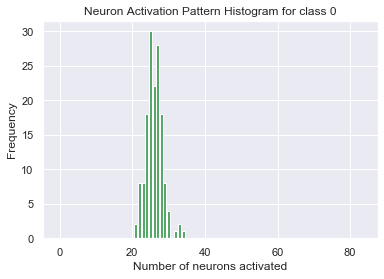

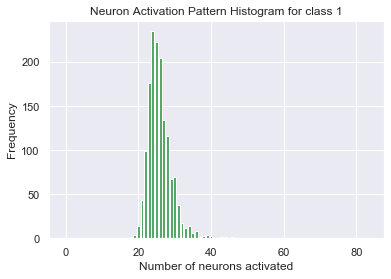

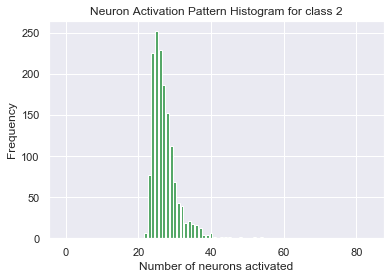

In [33]:
metric2.printMetricQuantity(0)
metric2.printMetricQuantity(1)
metric2.printMetricQuantity(2)